Le but ici de cette première tache est de créer un "raster plot" qui montre la reproducibilité d'un train de spike avec des répétitions du même stimulus. En particulier, nous allons essayer de répliquer la figure 1 de [Mainen & Sejnowski (1995)](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.299.8560&rep=rep1&type=pdf). 

Ce notebook a été élaboré lors d'un TP dans le cadre du [Master 1 de sciences cognitives de l'Université d'Aix-Marseille](https://formations.univ-amu.fr/ME5HSC.html).
<!-- TEASER_END -->

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
fig_width = 15
phi = (np.sqrt(5)+1)/2
phi = phi**2

# Mainen & Sejnowski, 1995

## contexte
Le but de cette première tache est de créer un "raster plot" qui montre la reproducibilité d'un train de spike avec des répétitions du même stimulus, comme dans ce travail dans la [rétine de rongeurs](https://laurentperrinet.github.io/2019-04-03_a_course_on_vision_and_modelization/#/1/3) ou dans le [cortex (V1) du chat](https://laurentperrinet.github.io/2019-04-03_a_course_on_vision_and_modelization/#/1/6).

Ici, nous allons essayer de répliquer la figure 1 de [Mainen & Sejnowski (1995)](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.299.8560&rep=rep1&type=pdf):

![Mainen Sejnowski 1995](http://i.stack.imgur.com/ixnrz.png "figure 1")


QUESTION: écrire un résumé rapide du papier (max 5 lignes) et pourquoi ce résultat est *a priori* surprenant:

REPONSE: Le but de l’étude était de déterminer directement la précision temporelle avec laquelle les neurones corticaux sont capables d'encoder un stimulus dans un train de pics. Lors d'un examen de la fiabilité de la génération de pics à l'aide d'enregistrements de neurones dans des tranches néocorticales de rats. 
 Dans cet article les auteurs ont étudié la réponse d'un neurone de la couche 5 du cortex en fonction de deux types de stimuli. Le résultat principal semble *a priori* surprenant car on s'attendrait à obtenir une réponse reproductible pour un signal continu et une réponse non reproductible pour une sigal bruité, or, cet article semble démontrer l'inverse. 


# représentation du temps

In [2]:
dt = .5 # pas de temps
time = np.arange(0, 1000, dt)

Création d'une fonction temporelle (version séquentielle):

In [3]:
start = 150
end = 750
value = 200

def Inp(time=time, start=start, end=end, value=value):
    x=[]
    for t in range(len(time)):
        if start < time[t] < end :
            x.append(value)
        else:
            x.append(0)
    return x

I = Inp(time)


In [4]:
%%timeit
I = Inp(time)

1.63 ms ± 100 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


version vectorisée:

In [5]:
def Inp(time=time, start=start, end=end, value=value):
    I = np.zeros_like(time)
    I[time>start] = value
    I[time>end] = 0
    return I
  
I = Inp(time)

In [6]:
%%timeit
I = Inp(time)

21.3 µs ± 8.13 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


QUESTION: essayer de décrire pourquoi le temps de calcul pour créer le vecteur est différent dans les deux versions:

REPONSE: Le temps de calcul est plus rapide quand le code est vectorisé. La vectorisation automatique du code, est une fonctionnalité du compilateur qui permet à certaines parties des programmes séquentiels d'être transformés en programme parallèles équivalents afin de produire du code qui sera optimisé pour un l'unité centrale de traitement (CPU).

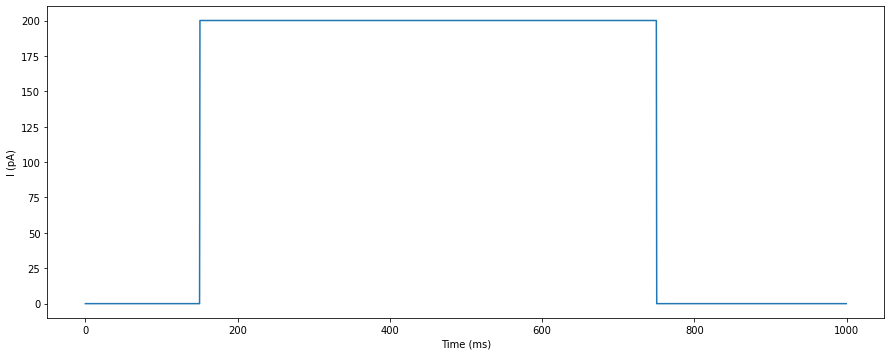

In [7]:
fig, ax = plt.subplots(figsize=(fig_width, fig_width/phi))
ax.plot(time, I)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('I (pA)');

## un modèle simple de neurone intègre-et-tire `leaky_IF`

Commençons avec cet équation du potentiel membranaire:

$$
\tau \cdot \frac{dV}{dt} = -(V - V_{rest}) + R*I(t)
$$

avec émission d'un "spike" si $V > V_{rest}$, et alors $V= V_{rest}$ pour $3 ms$.


In [8]:
Vthreshold = -53
def leaky_IF(time=time, inp=I, tau=30, v0=-69, R=0.11, 
                Vthreshold=Vthreshold, Vreset=-80, Vspike=30, 
                VRest=-70):
    V = np.ones_like(time)*v0
    dt = time[1]
    for t in range(len(time)-1):
        dV = dt * (-(V[t] - VRest) + R*inp[t])/tau
        V[t+1] = V[t] + dV
        
        if V[t]>Vthreshold:
            V[t+1]= Vspike
        if V[t] == Vspike:
            V[t+1]=Vreset
         
    return V


QUESTION: régler le paramètre $R$ pour obtenir une dizaine de potentiels d'action - quel est l'interprétation de ce paramètre et quelles est l'unité de mesure?

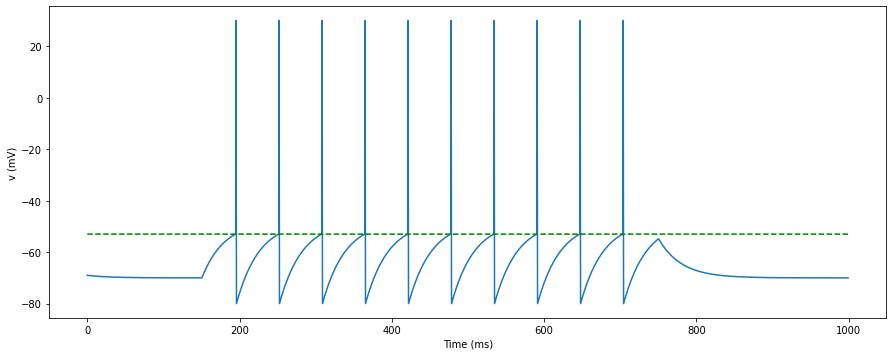

In [9]:
V = leaky_IF(time, I)
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, V)
ax.plot(time, np.ones_like(time)*Vthreshold, 'g--')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('v (mV)');

REPONSE: Ce paramètre est la résistance de notre modèle, représentée en $\Omega$ (ohm). On observe qu'un $R$ grand nous fera atteindre le V(seuil) plus rapidement et fournira un profil de décharge haute fréquence contrairement à un $R$ plus faible.

QUESTION: quel est l'effet de $I_0$ sur la fréquence de décharge?

I_0= 125.0


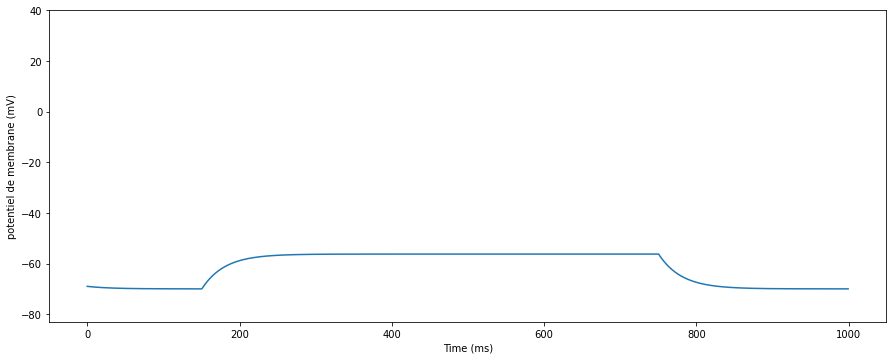

I_0= 218.75


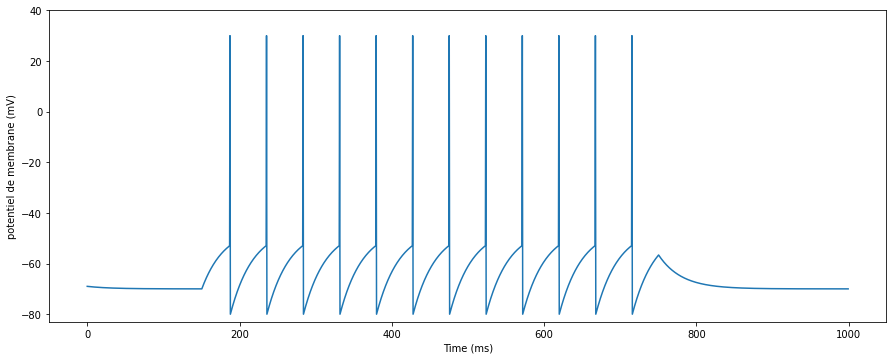

I_0= 312.5


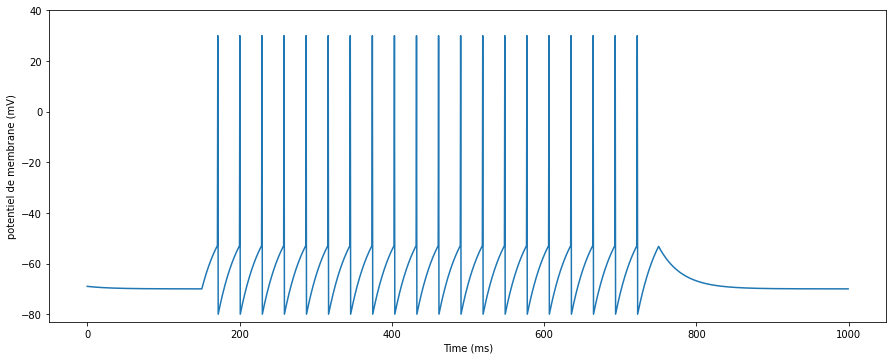

I_0= 406.25


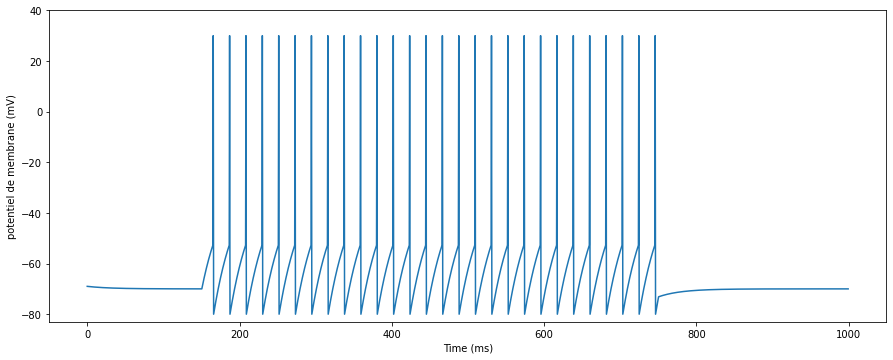

I_0= 500.0


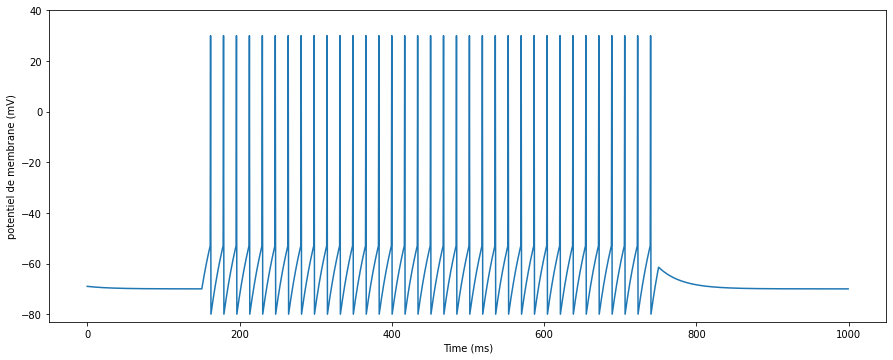

In [10]:
for rho in np.linspace(0.5, 2.0, 5):
    I_0_ = rho*250
    print('I_0=', I_0_)
    V= leaky_IF(time, Inp(value=I_0_))

    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
    ax.plot(time, V)
    ax.set_ylim(-83, 40)
    ax.set_ylabel("potentiel de membrane (mV)")
    ax.set_xlabel('Time (ms)')

    plt.show()

REPONSE: La valeur `I0` mesure l'intensité du courant entrant injecté, correspond à l'injection d'un courant constant. Plus la valeur est haute, plus la fréquence de décharge augmente.

Plusieurs essais montrent que c'est parfaitement reproductible, contrairement à la figure:

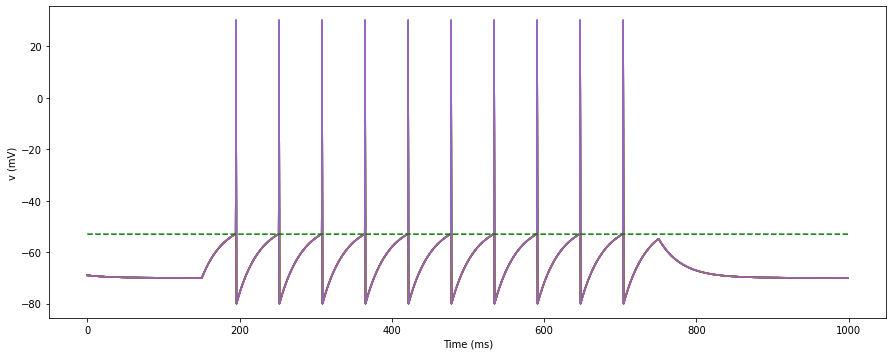

In [11]:
n_trials = 15
V1 = np.zeros((n_trials,len(time)))
for i in range(n_trials):
    V1[i, :] = leaky_IF()

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, V1.T)
ax.plot(time, np.ones_like(time)*Vthreshold, 'g--')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('v (mV)');

QUESTION: ce modèle semble ne pas reproduire les résultats, une explication?

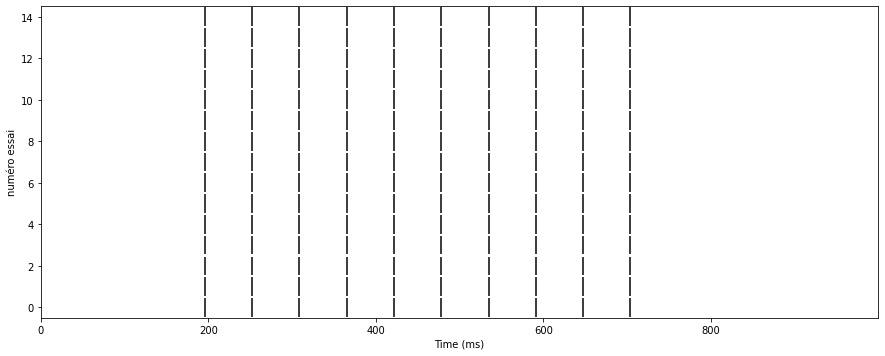

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.eventplot([dt*np.where(V1.T[:, i] == 30)[0] for i in range(0, n_trials)], 
              colors='black', lineoffsets=1, linelengths=0.9)
ax.set_ylabel('numéro essai')
ax.set_xlabel('Time (ms)')
ax.set_xlim(time.min(), time.max())
ax.set_ylim(-.5, n_trials-.5);

REPONSE: Ce modèle ne semble pas reproduire les résultats, car il n'y a pas de variabilité dans le signal d'entrée. Il faut ajouter du bruit dans ce signal pour imiter l'entrée de nature variable qu'aurait un neurone in-vivo.

## Création d'un input bruité

Un modèle linéaire de diffusion permet de créer simplement un bruit:

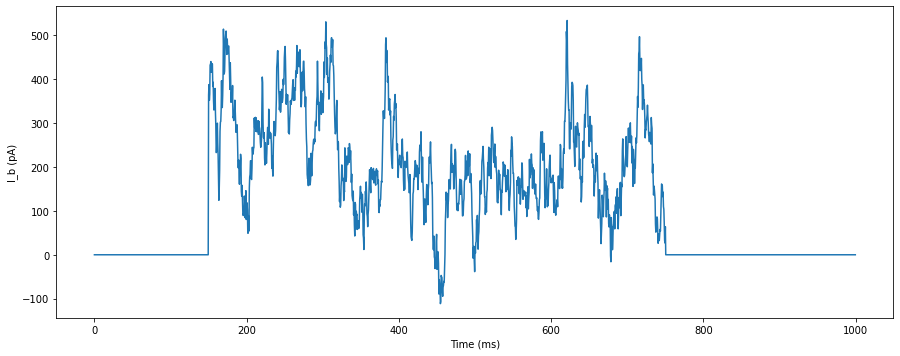

In [13]:
def Bruit(time=time, tau_n=15, I_n=1000, I_0=200, start=start, end=end):
    dt = time[1]
    x=np.ones_like(time)
    for t in range(len(x)-1):
        n = np.random.randn()*I_n
        x[t+1]=(1-dt/tau_n)*x[t]+ (dt*n/tau_n)
    
    x += I_0
    x[time<start], x[time>end] = 0, 0
    
    return x

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, Bruit())
ax.set_xlabel('Time (ms)')
ax.set_ylabel('I_b (pA)');

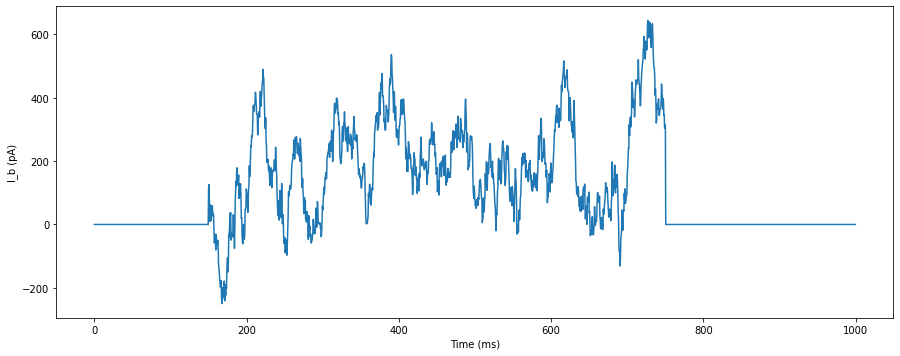

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, Bruit())
ax.set_xlabel('Time (ms)')
ax.set_ylabel('I_b (pA)');

QUESTION: ce modèle représente-t-il bien celui dans le papier? régler $I_n$ et $I_0$ pour obtenir quelque chose qui corresponde mieux.

REPONSE: Les paramètres `In = 1000pA` et `I0 = 200pA` donnent un ordre de grandeur de ce qui est présenté dans le papier.

## Neurone LIF avec Input bruité

Observons maintenant la réponse de notre neurone LIF à cette entrée:

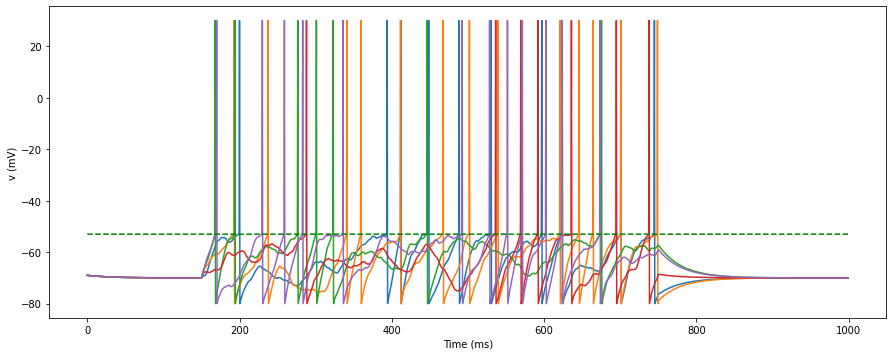

In [15]:
n_trials = 5
V1 = np.zeros((n_trials,len(time)))

for i in range(n_trials):
    V1[i, :] = leaky_IF(time, Bruit())

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, V1.T)
ax.plot(time, np.ones_like(time)*Vthreshold, 'g--')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('v (mV)');

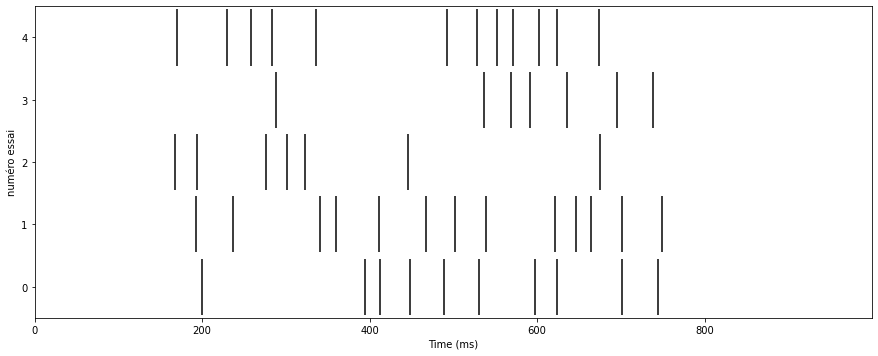

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.eventplot([dt*np.where(V1.T[:, i] == 30)[0] for i in range(0, n_trials)], 
              colors='black', lineoffsets=1, linelengths=0.9);
ax.set_ylabel('numéro essai')
ax.set_xlabel('Time (ms)')
ax.set_xlim(time.min(), time.max())
ax.set_ylim(-.5, n_trials-.5);

QUESTION: régler $I_n$ et $I_0$ pour obtenir quelque chose qui corresponde mieux à la sortie observée:

I_0= 100.0


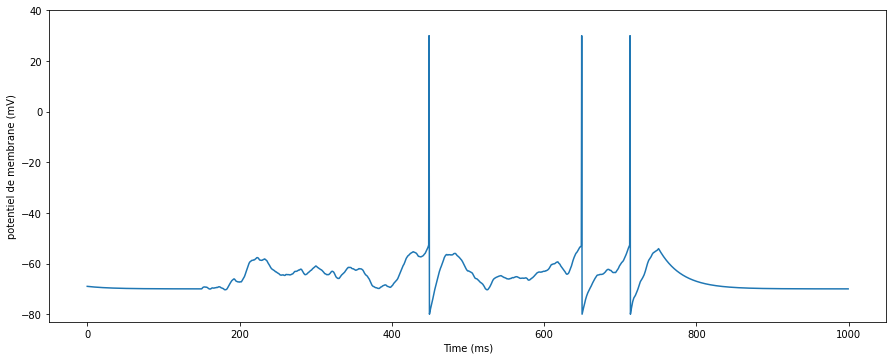

I_0= 135.0


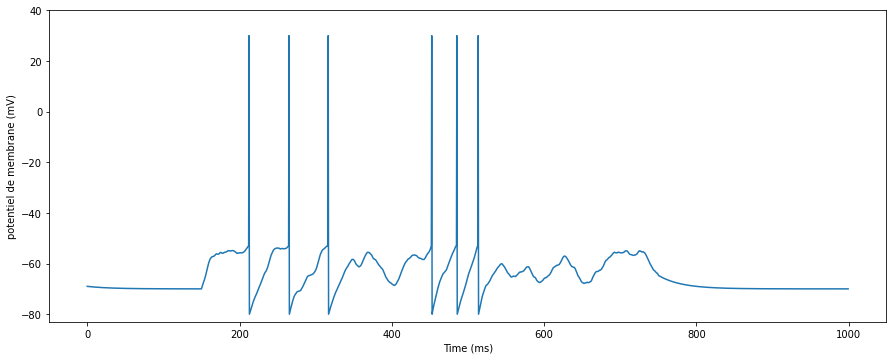

I_0= 170.0


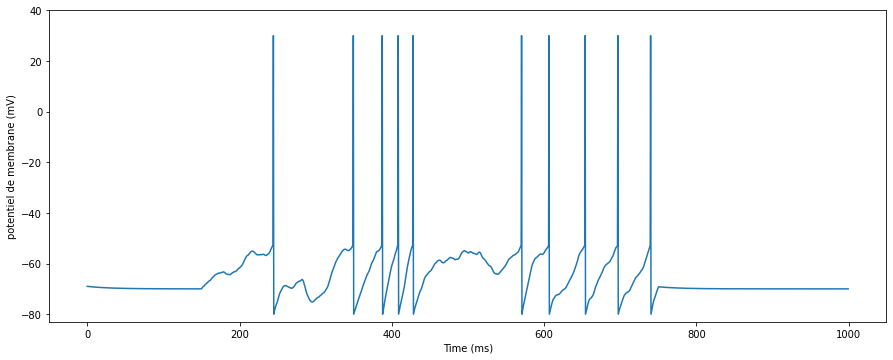

I_0= 204.99999999999997


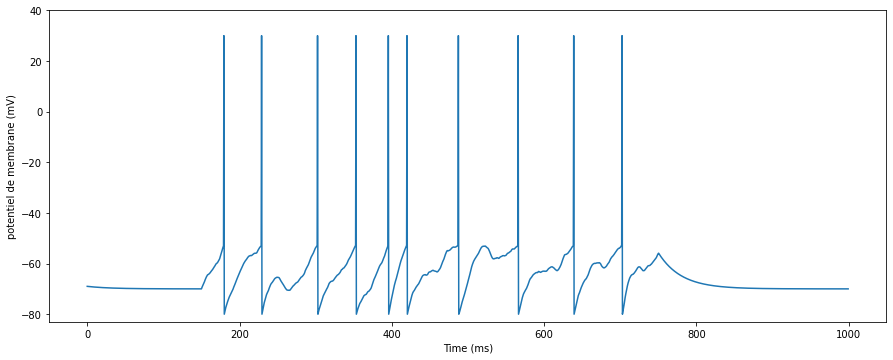

I_0= 240.0


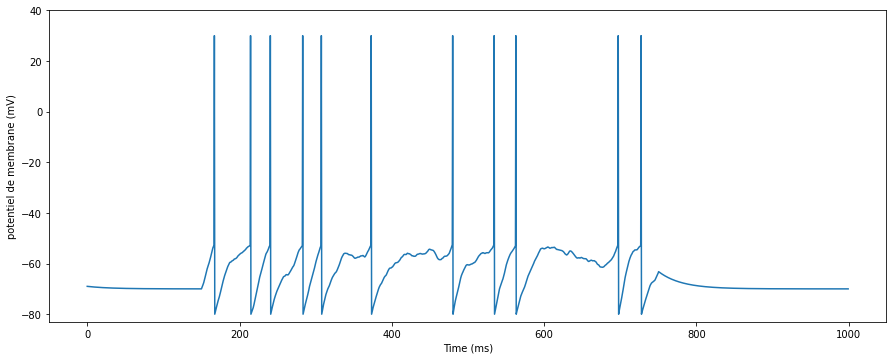

In [17]:
for rho in np.linspace(0.5, 1.2, 5):
    I_0_ = rho*200
    print('I_0=', I_0_)
    V= leaky_IF(time, Bruit(time, I_n=1000, I_0=I_0_))

    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
    ax.plot(time, V)
    ax.set_ylim(-83, 40)
    ax.set_ylabel("potentiel de membrane (mV)")
    ax.set_xlabel('Time (ms)')

    plt.show()

REPONSE: `I0 = 200` semble qualitativement correct.

I_n= 600.0


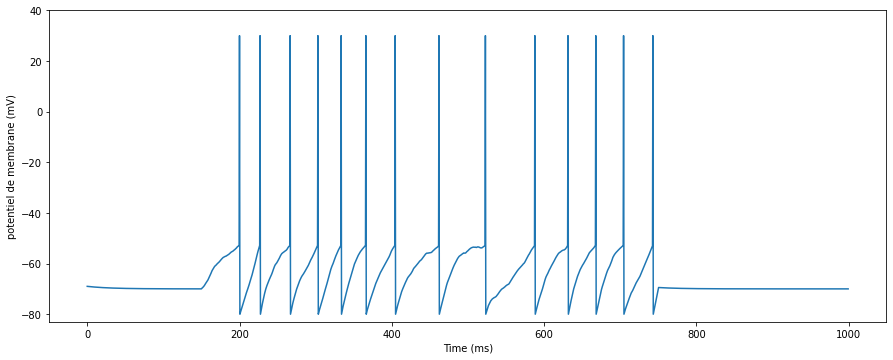

I_n= 799.9999999999999


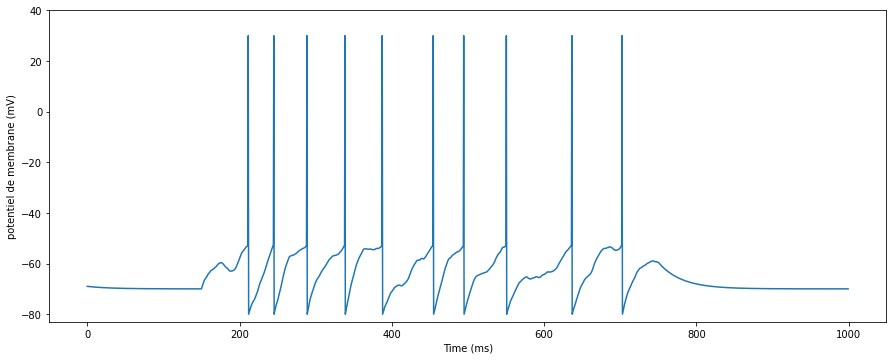

I_n= 1000.0


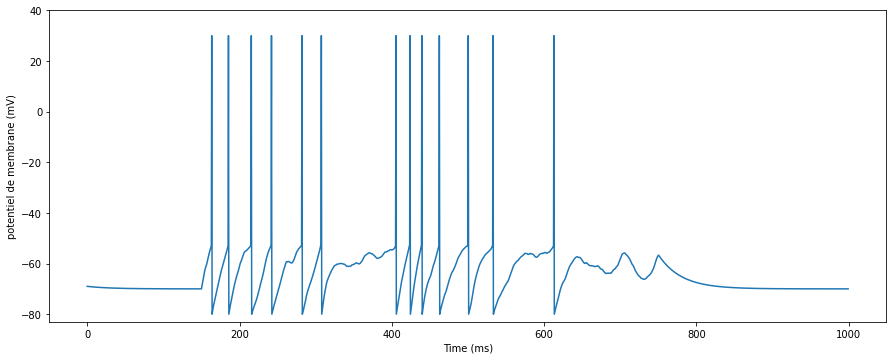

I_n= 1200.0


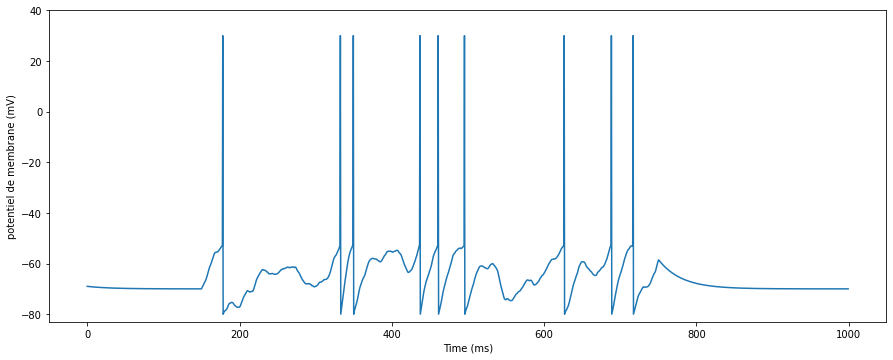

I_n= 1400.0


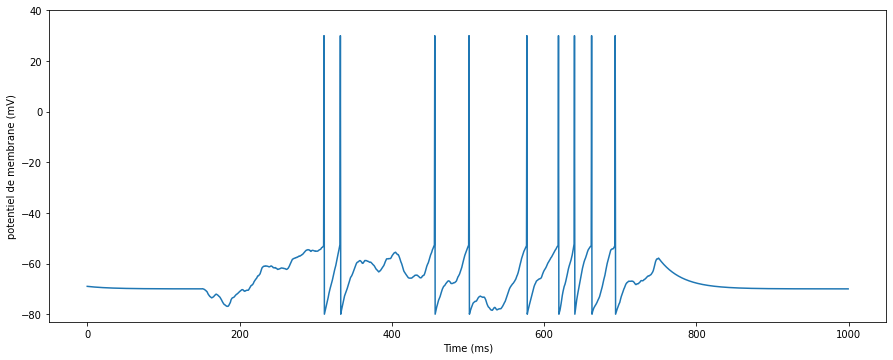

In [18]:
for rho in np.linspace(0.6, 1.4, 5):
    I_n_ = rho*1000
    print('I_n=', I_n_)
    V= leaky_IF(time, Bruit(time, I_n=I_n_, I_0=200))

    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
    ax.plot(time, V)
    ax.set_ylim(-83, 40)
    ax.set_ylabel("potentiel de membrane (mV)")
    ax.set_xlabel('Time (ms)')

    plt.show()

QUESTION: obtient-on bien quelque chose de reproductible?

REPONSE: Non, à chaque nouvelle exécution, les graphes seront différents, et ce quelques soient les valeurs de I_0, et dans la mesure ou la valeur de I_n n'approche pas de 0 (dans ce cas il n'y aurait plus de variabilité et on aurait plus de bruit). Cela a pour origine le bruit utilisé dans le modèle. Celui ci change à chaque nouvelle simulation du modèle, simulant un stimulus différent, la réponse du neurone n'est donc jamais la même:

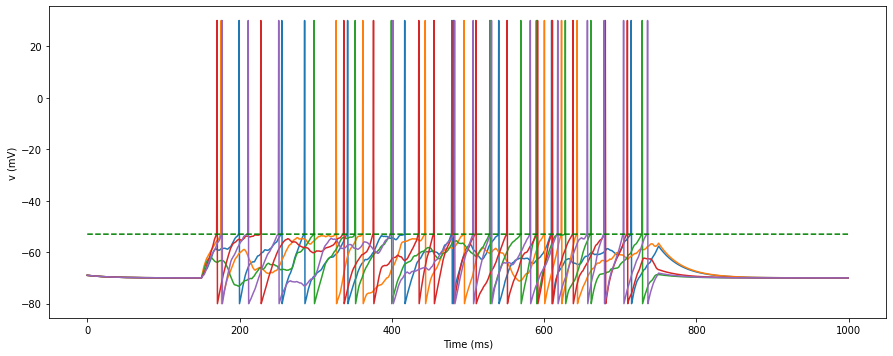

In [19]:
n_trials = 5
V1 = np.zeros((n_trials,len(time)))

for i in range(n_trials):
    V1[i, :] = leaky_IF(time, Bruit(time, I_n=1000, I_0=200))

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, V1.T)
ax.plot(time, np.ones_like(time)*Vthreshold, 'g--')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('v (mV)');

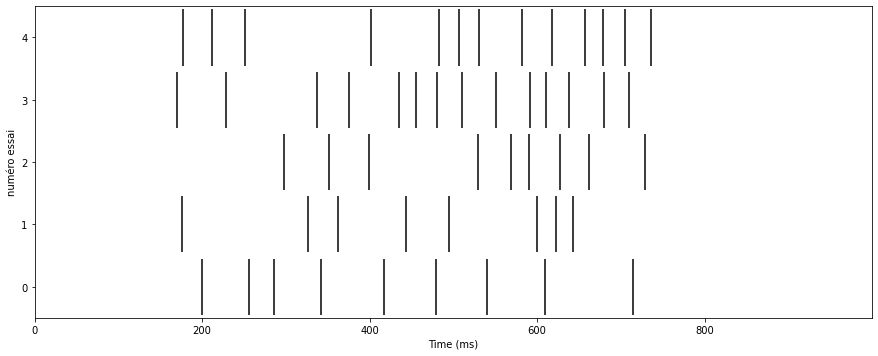

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.eventplot([dt*np.where(V1.T[:, i] == 30)[0] for i in range(0, n_trials)], 
              colors='black', lineoffsets=1, linelengths=0.9);
ax.set_ylabel('numéro essai');
ax.set_xlabel('Time (ms)')
ax.set_xlim(time.min(), time.max())
ax.set_ylim(-.5, n_trials-.5);

## bruit gelé

QUESTION : quel est la nature du bruit utilisé dans l'article? pourquoi peut-on le décrire comme un [bruit gelé](https://www.oxfordreference.com/view/10.1093/oi/authority.20110803095836900) ?

REPONSE: La nature du bruit utilisé dans l'article est un bruit blanc Gaussien filtré généré par l'ordinateur. Le bruit blanc gaussien est un bruit blanc qui suit une loi normale de moyenne et variance données. On peut le décrire comme un "bruit gelé", c'est un bruit qui se répète à l'identique au cours des essais.

QUESTION : comment implanter un tel bruit? que savez-vous des générateurs de bruit utilisés dans un ordinateur?

REPONSE: On peut implanter ce bruit par informatique en "gelant" les inputs.
Les générateurs de bruit utilisés dans un ordinateur, servent à générer un signal de bruit précis tout en maintenant une haute précision du ratio entre le bruit fourni par l'utilisateur et le bruit interne, au dessus de la gamme étendue du niveau de puissance et de fréquence du signal. Pour générer un bruit gelé, il suffit de fixer l'état de notre machine dans son processus aléatoire, cela peut se faire via la fonction `random.seed` de la bibliothèque `numpy` par exemple:

In [21]:
help(np.random.seed)

Help on built-in function seed:

seed(...) method of numpy.random.mtrand.RandomState instance
    seed(self, seed=None)
    
    Reseed a legacy MT19937 BitGenerator
    
    Notes
    -----
    This is a convenience, legacy function.
    
    The best practice is to **not** reseed a BitGenerator, rather to
    recreate a new one. This method is here for legacy reasons.
    This example demonstrates best practice.
    
    >>> from numpy.random import MT19937
    >>> from numpy.random import RandomState, SeedSequence
    >>> rs = RandomState(MT19937(SeedSequence(123456789)))
    # Later, you want to restart the stream
    >>> rs = RandomState(MT19937(SeedSequence(987654321)))



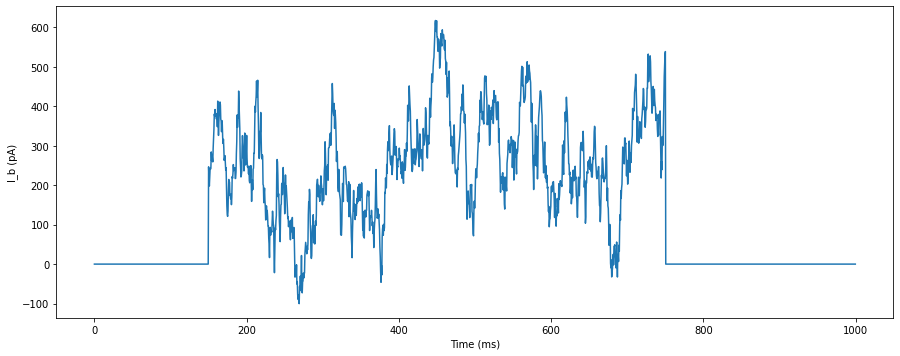

In [22]:
def Bruit(time=time, tau_n=15, I_n=1000, I_0=200, seed=42, start=start, end=end):
    np.random.seed(seed)
    dt = time[1]
    x=np.ones_like(time)
    for t in range(len(x)-1):
        n = np.random.randn()*I_n
        x[t+1] = (1-dt/tau_n)*x[t]+ (dt*n/tau_n)
    
    x += I_0
    x[time<start], x[time>end] = 0,0
    
    return x

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, Bruit())
ax.set_xlabel('Time (ms)')
ax.set_ylabel('I_b (pA)');

On vérifie que si on relance la fonction générant le bruit aléatoire, on obtient le même signal:

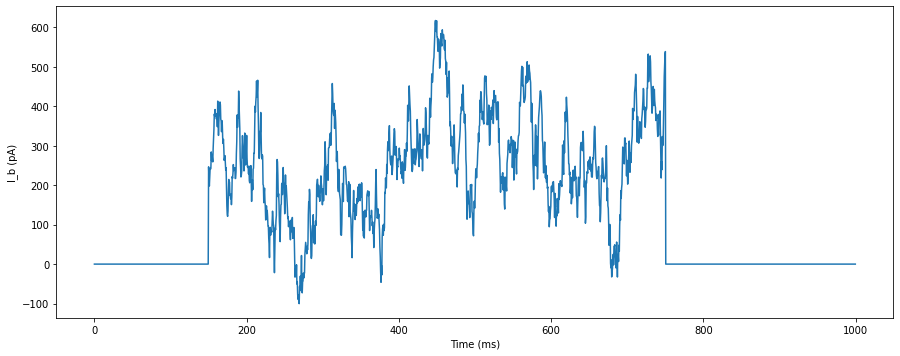

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, Bruit())
ax.set_xlabel('Time (ms)')
ax.set_ylabel('I_b (pA)');

## Plusieurs trials
Ici on montre le maintien du temps des spikes en utilisant un input bruité (bruit gelé)

QUESTION: régler le paramètre $I_0$ et $I_n$ pour obtenir une dizaine de potentiels d'action:

number of spikes per trial : [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10]


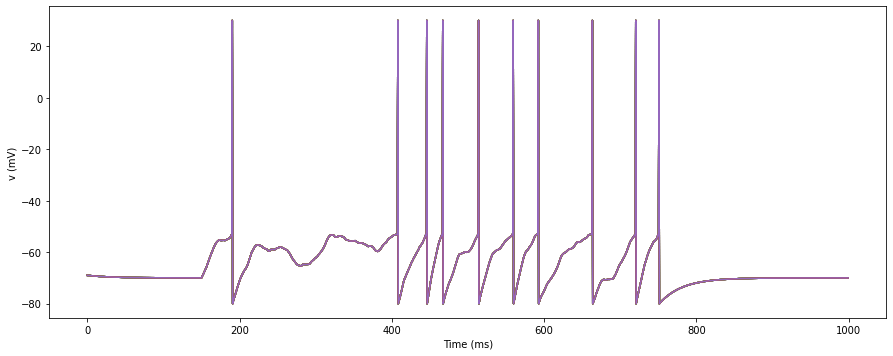

In [24]:
n_trials = 25
V1 = np.zeros((n_trials,len(time)))

for i in range(n_trials):
    V1[i, :] = leaky_IF(time, Bruit(I_n=800, I_0=150))

print('number of spikes per trial :', (V1>0).sum(axis=1))
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, V1.T)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('v (mV)');

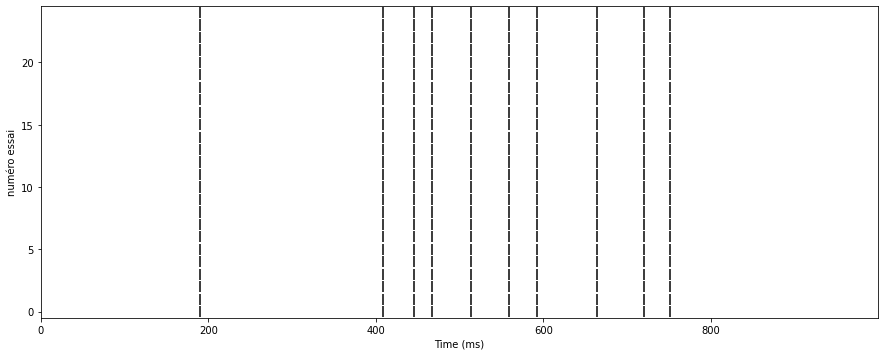

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.eventplot([dt*np.where(V1.T[:, i] == 30)[0] for i in range(0, n_trials)], 
              colors='black', lineoffsets=1, linelengths=0.9);
ax.set_ylabel('numéro essai')
ax.set_xlabel('Time (ms)')
ax.set_xlim(time.min(), time.max())
ax.set_ylim(-.5, n_trials-.5);

REPONSE: avec une forte amplitude du bruit (`I_n=800, I_0=150`), on reproduit le paneau B: avec un bruit gelé, les traces des neurones sont reproductibles.

Celà prouve aussi que l'on a "oublié" d'inclure un bruit intrinsèque à la dynamique du neurone:

In [26]:
def leaky_IF(time=time, inp=I, tau=30, v0=-65, R=0.11, 
                Vthreshold =-53, Vreset = -80, Vspike=30, 
                VRest=-70, b=100, seed=None):
    np.random.seed(seed)
    V = np.ones_like(time)*v0
    dt = time[1]
    for t in range(len(time)-1):
        n=np.random.randn()
        dV = dt * (-(V[t] - VRest) + R*(inp[t]+b*n))/tau
        V[t+1] = V[t] + dV
        
        if V[t]>Vthreshold:
            V[t+1]= Vspike
        if V[t] == Vspike:
            V[t+1]=Vreset
         
    return V


Plusieurs essais montrent qu'avec un créneau les temps des spikes perdent leur reproducibilité, comme sur la figure:

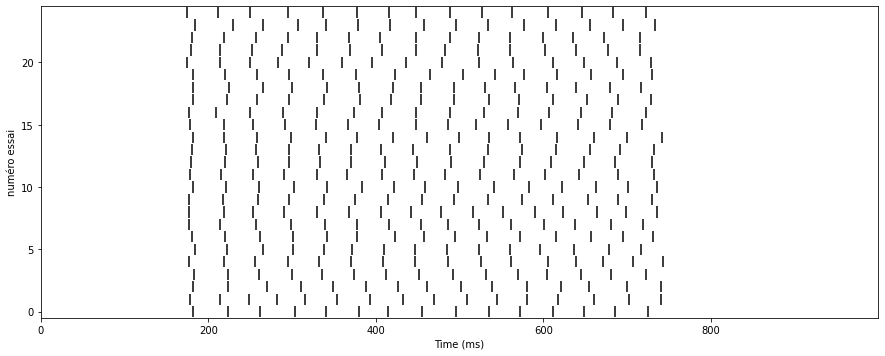

In [27]:
n_trials = 25
V1 = np.zeros((n_trials,len(time)))

for i in range(n_trials):
    V1[i, :] = leaky_IF(time, Bruit(I_n=0, I_0=250))


fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.eventplot([dt*np.where(V1.T[:, i] == 30)[0] for i in range(0, n_trials)], 
              colors='black', lineoffsets=1, linelengths=0.9);
ax.set_ylabel('numéro essai')
ax.set_xlabel('Time (ms)')
ax.set_xlim(time.min(), time.max())
ax.set_ylim(-.5, n_trials-.5);

QUESTION : régler $I_0$ et $I_n$ pour obtenir un nombre qualitativement similaire de spikes en sortie du neurone. Pour celà, essayer de controler le nombre de spikes :

I_n = 700.0
number of spikes per trial : [10  9  9  9 10  9 10  9 10  9  9  9  9  9  9  9 10 10  9 10  9 10  9  8
 10]


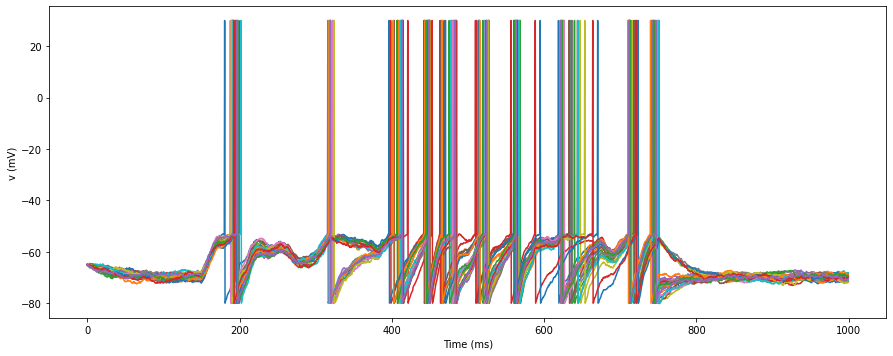

I_n = 850.0
number of spikes per trial : [11 11 10  9 10 11 10 10 10  9 10 10 11 10  9 10 10 11 11 10 11 10 10 11
 11]


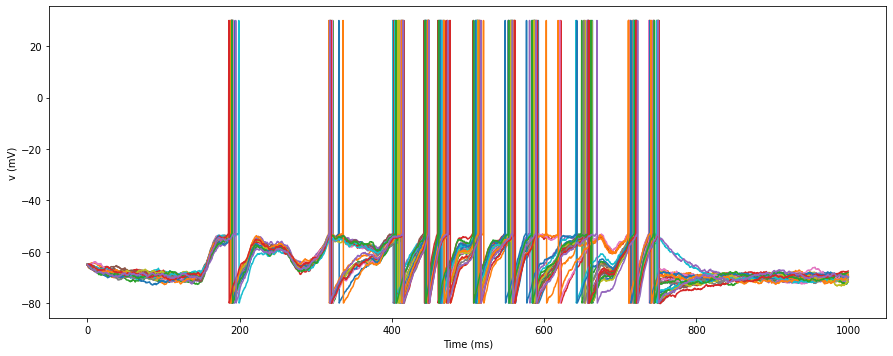

I_n = 1000.0
number of spikes per trial : [12 12 11 11 11 11 12 12 12 11 11 11 11 11 11 11 11 11 10 12 11 11 12 12
 10]


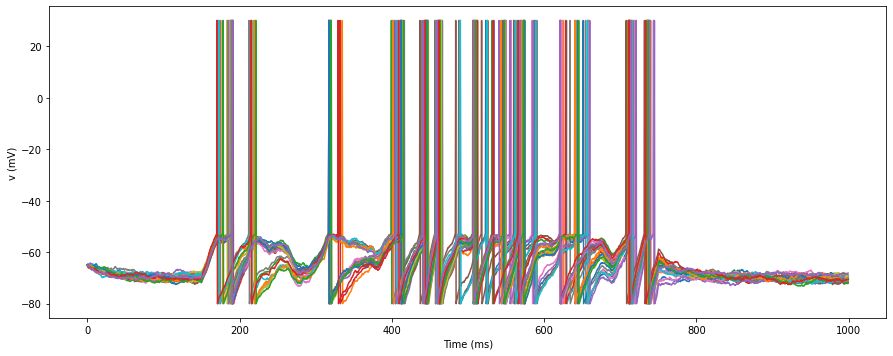

I_n = 1150.0
number of spikes per trial : [13 12 12 12 11 12 12 13 13 12 12 11 12 12 11 12 13 13 11 12 12 12 12 12
 11]


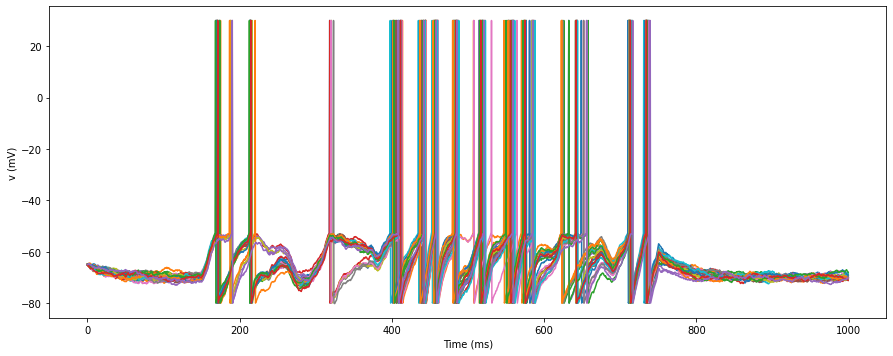

I_n = 1300.0
number of spikes per trial : [13 12 13 13 13 12 12 13 12 12 14 13 14 13 12 13 12 13 13 13 13 12 13 12
 12]


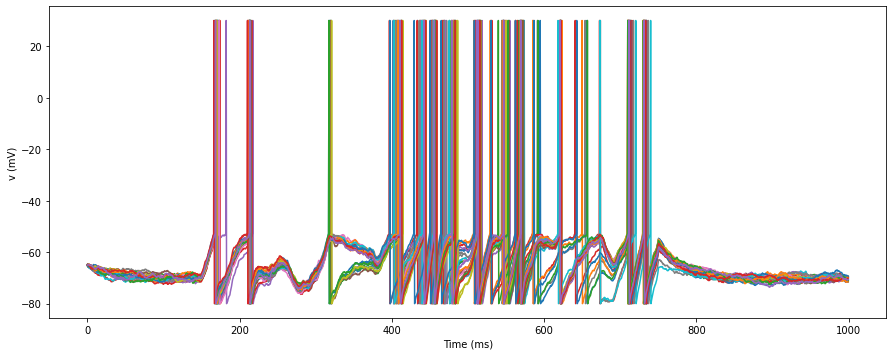

In [28]:
for rho in np.linspace(0.7, 1.3, 5):
    I_n_ = rho*1000
    print('I_n =', I_n_)
    VA = np.zeros((n_trials,len(time)))

    for i in range(n_trials):
        VA[i, :] = leaky_IF(time, Bruit(I_n=I_n_, I_0=150))

    print('number of spikes per trial :', (VA>0).sum(axis=1))
    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
    ax.plot(time, VA.T)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('v (mV)');
    plt.show()


QUESTION : voir l'influence de $I_0$ sur le comportement


rho= 0.7
number of spikes per trial : [8 8 8 7 8 8 7 7 8 8 8 8 8 7 8 8 8 7 8 8 7 7 8 8 8]


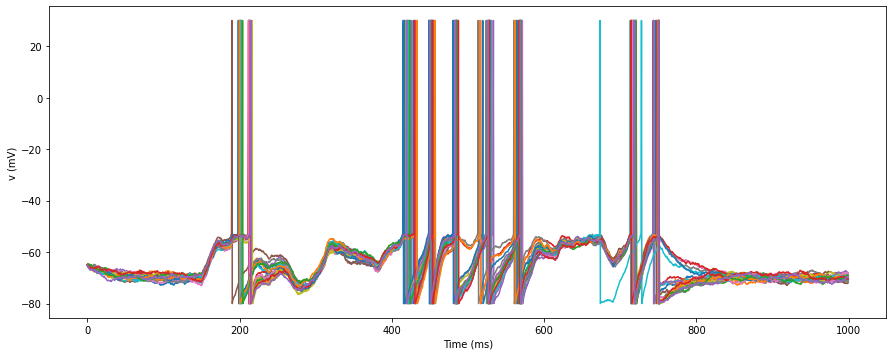

rho= 0.85
number of spikes per trial : [ 9  9  9  9 10 10  9  9  9  9  9  9  9  9  9 10  9 11  9  9  9 10 10  9
  9]


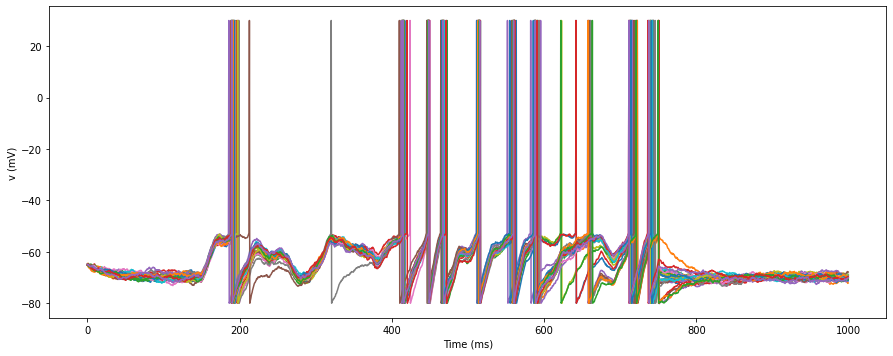

rho= 1.0
number of spikes per trial : [10 11 12 11 12 11 11 11 10 12 11 11 11 11 11 12 11 11 13 11 11 10 11 10
 11]


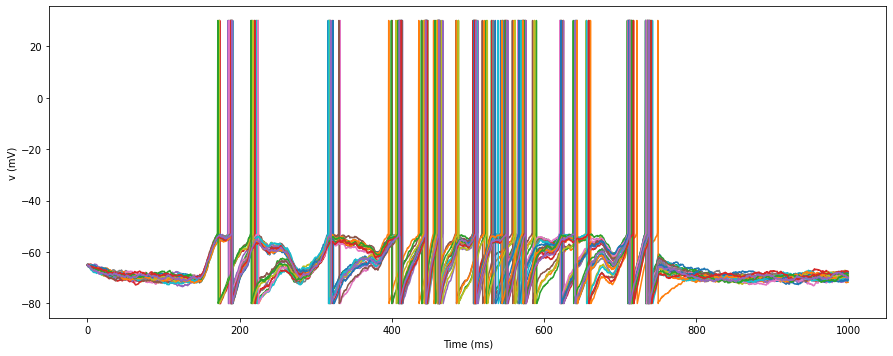

rho= 1.15
number of spikes per trial : [13 13 14 13 13 13 13 14 13 13 13 14 13 14 12 13 13 13 13 13 14 12 13 13
 13]


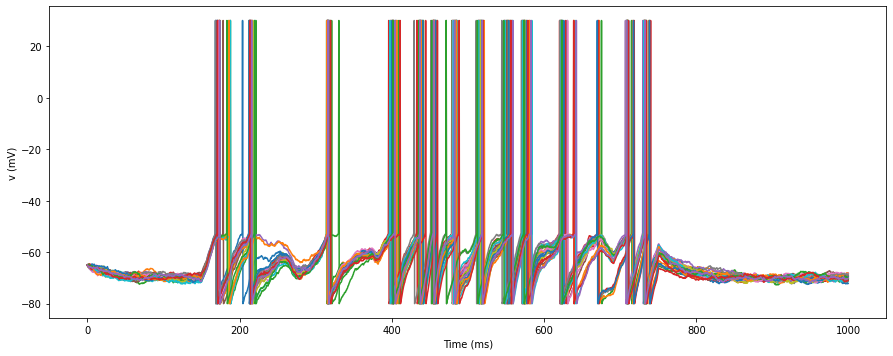

rho= 1.3
number of spikes per trial : [15 15 15 14 15 15 15 15 15 15 15 15 15 15 14 15 15 14 15 14 15 14 14 14
 14]


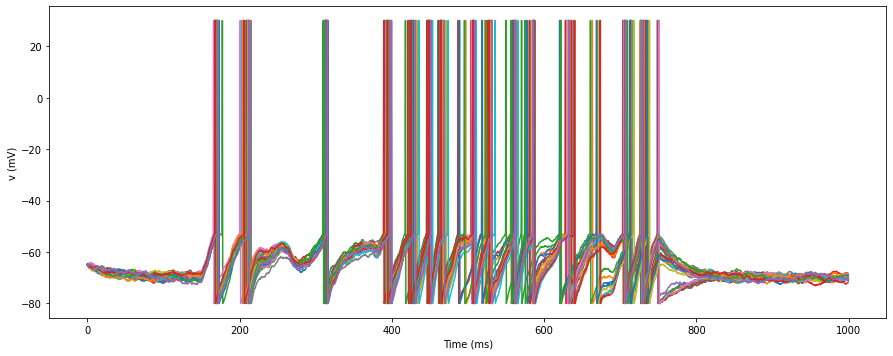

In [29]:
for rho in np.linspace(0.7, 1.3, 5):
    print('rho=', rho)
    VA = np.zeros((n_trials,len(time)))

    for i in range(n_trials):
        VA[i, :] = leaky_IF(time, Bruit(I_n=1000, I_0=rho*150))

    print('number of spikes per trial :', (VA>0).sum(axis=1))  
    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
    ax.plot(time, VA.T)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('v (mV)');
    plt.show()

REPONSE: Le couple de paramètres `I_n=1000, I_0=150` correspond bien

QUESTION : voir l'influence de $I_0$ sur le comportement, *quand le bruit est nul* :

I_0_= 225.0
number of spikes per trial : [13 13 13 13 13 13 13 13 13 13 13 13 13 14 13 13 13 13 13 12 13 13 13 13
 13]


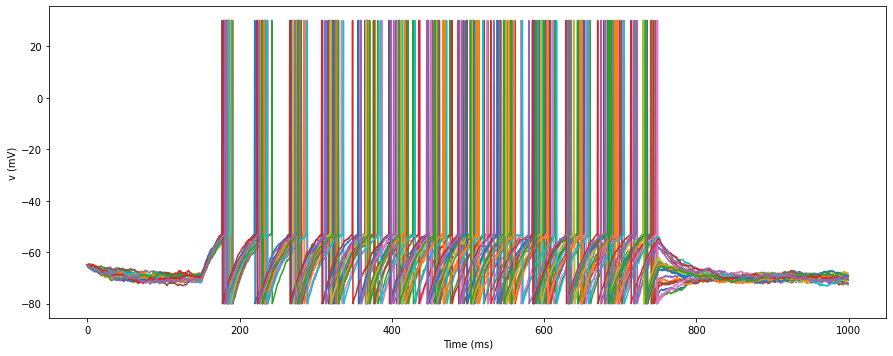

I_0_= 237.50000000000003
number of spikes per trial : [14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 15
 14]


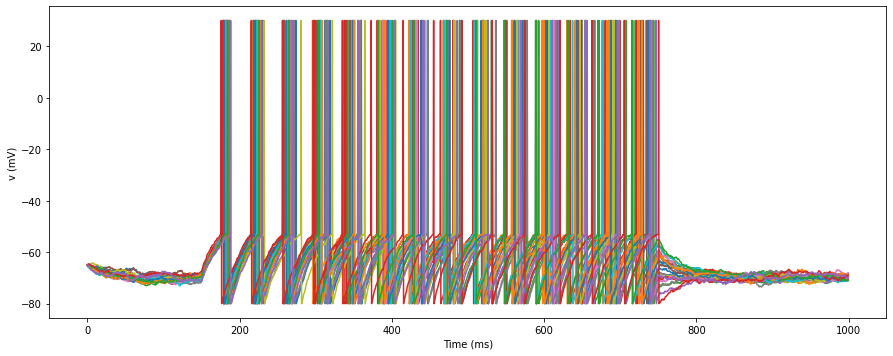

I_0_= 250.0
number of spikes per trial : [15 15 15 15 15 15 15 15 15 15 15 16 15 15 15 15 15 15 15 15 15 15 15 15
 15]


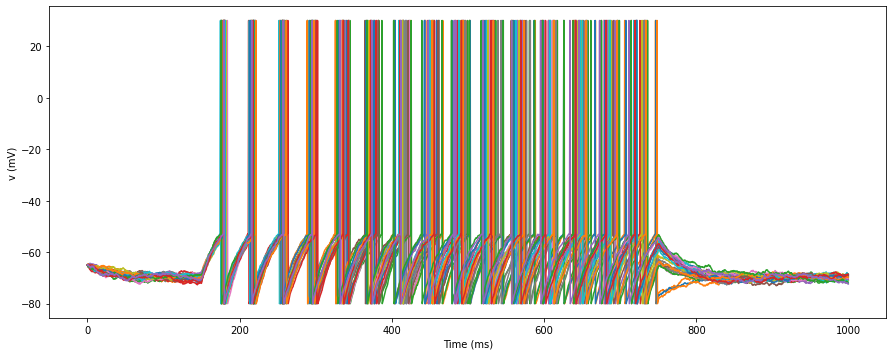

I_0_= 262.5
number of spikes per trial : [17 16 16 16 16 16 17 16 16 16 16 17 16 16 16 16 16 16 16 16 16 16 16 16
 16]


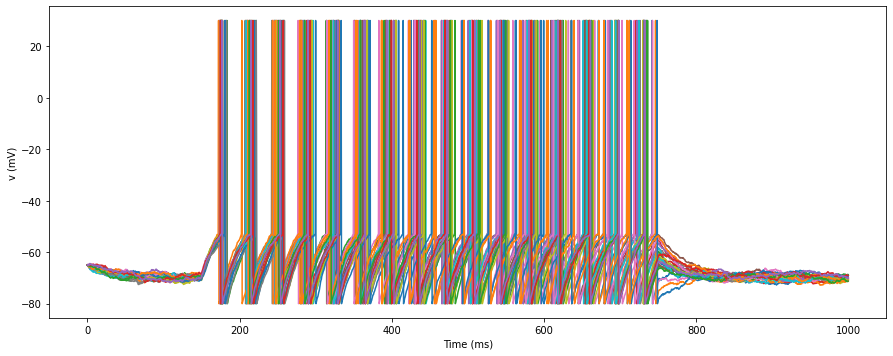

I_0_= 275.0
number of spikes per trial : [16 17 17 18 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 18 17 18 17
 17]


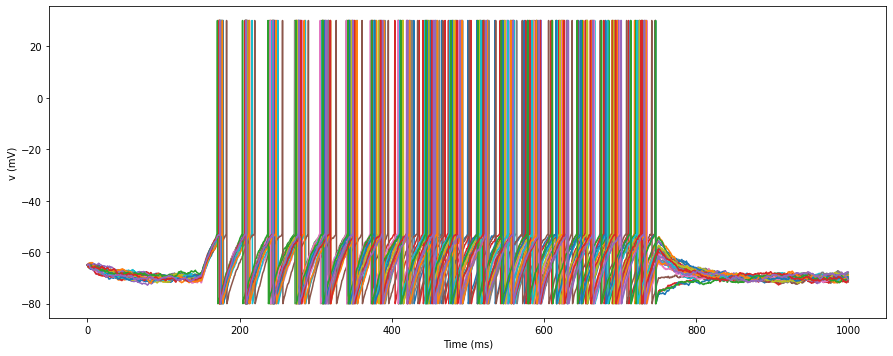

In [30]:
for rho in np.linspace(0.9, 1.1, 5):
    I_0_ = rho*250
    print('I_0_=', I_0_)
    VA = np.zeros((n_trials,len(time)))

    for i in range(n_trials):
        VA[i, :] = leaky_IF(time, Bruit(I_n=0, I_0=I_0_))

    print('number of spikes per trial :', (VA>0).sum(axis=1))
    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
    ax.plot(time, VA.T)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('v (mV)');
    plt.show()

QUESTION: reproduire le paneau A: quand le bruit est nul, les traces des neurones ne sont pas reproductibles:

number of spikes per trial : [15 15 15 15 15 14 15 15 15 15 15 15 15 15 15 15 15 15 16 15 15 15 15 15
 15]


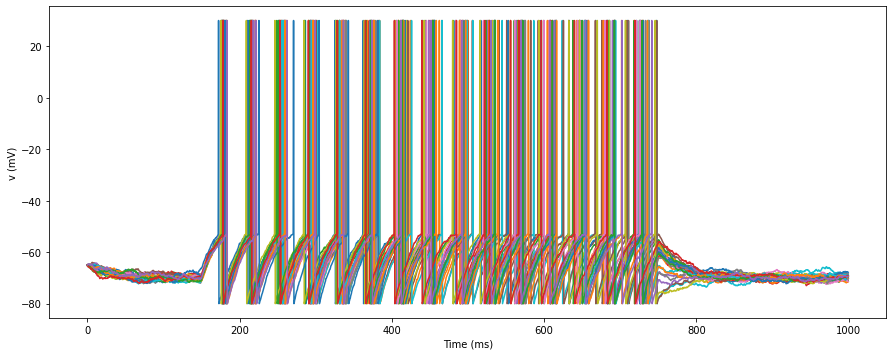

In [31]:
seed = 2020
VA = np.zeros((n_trials,len(time)))
b_A = Bruit(I_n=0, I_0=250, seed=seed)

for i in range(n_trials):
    VA[i, :] = leaky_IF(time, b_A)
    
print('number of spikes per trial :', (VA>0).sum(axis=1))
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, VA.T)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('v (mV)');

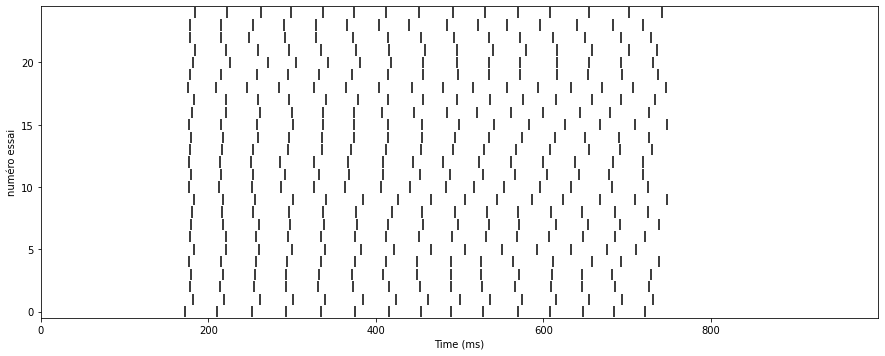

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.eventplot([dt*np.where(VA.T[:, i] == 30)[0] for i in range(0, n_trials)], 
              colors='black', lineoffsets=1, linelengths=0.9);
ax.set_ylabel('numéro essai')
ax.set_xlabel('Time (ms)')
ax.set_xlim(time.min(), time.max())
ax.set_ylim(-.5, n_trials-.5);


On reproduit le paneau B: avec un bruit gelé, les traces des neurones sont reproductibles, même quand le neurone possède un bruit intrinsèque:


number of spikes per trial : [11 10 10 10 10 11 11 11 11 11 11 11 10 11 11 11 11 10 10 11 11 10 10 11
 10]


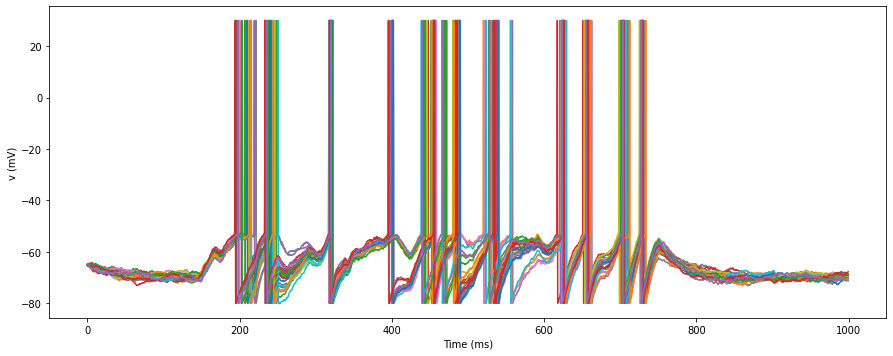

In [33]:
VB = np.zeros((n_trials, len(time)))
b_B = Bruit(I_n=1000, I_0=200, seed=seed)
for i in range(n_trials):
    VB[i, :] = leaky_IF(time, b_B)
    
print('number of spikes per trial :', (VB>0).sum(axis=1))
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(time, VB.T)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('v (mV)');

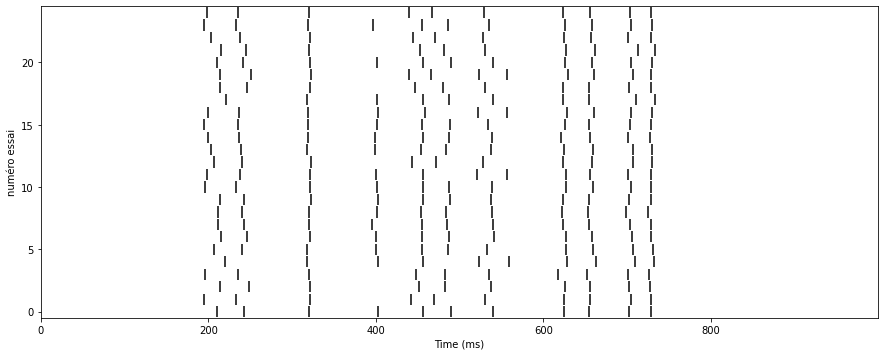

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.eventplot([dt*np.where(VB.T[:, i] == 30)[0] for i in range(0, n_trials)], 
              colors='black', lineoffsets=1, linelengths=0.9);
ax.set_ylabel('numéro essai')
ax.set_xlabel('Time (ms)')
ax.set_xlim(time.min(), time.max())
ax.set_ylim(-.5, n_trials-.5);

Pour résumer:

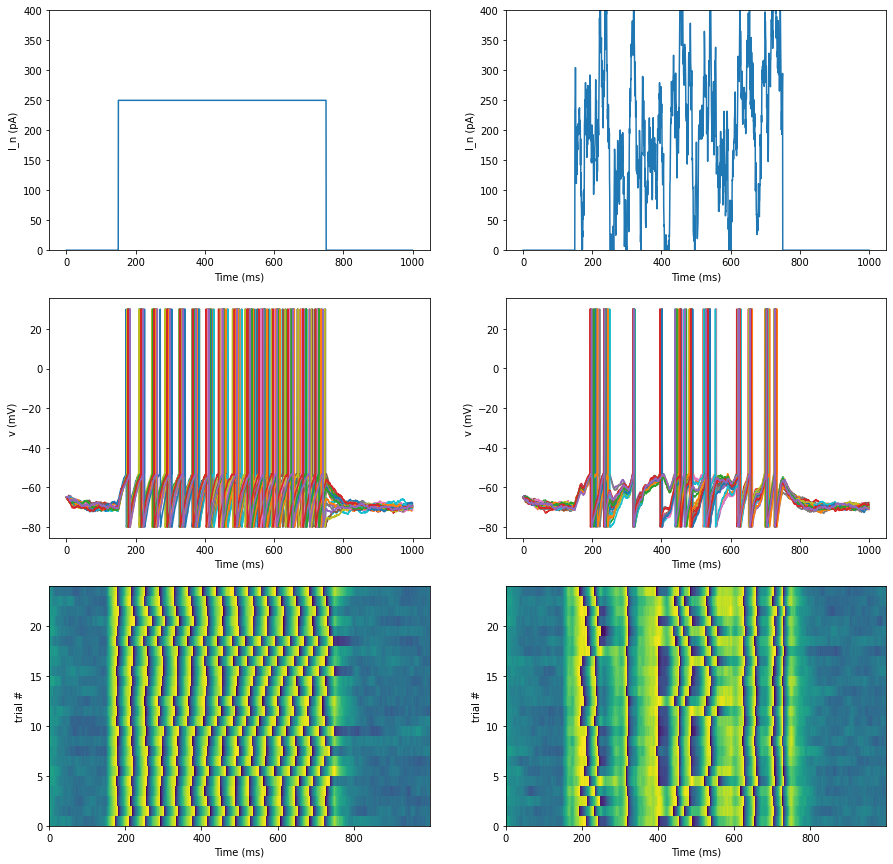

In [35]:
fig, axs = plt.subplots(3, 2, figsize=(fig_width, fig_width))

axs[0][0].plot(time, b_A)
axs[0][1].plot(time, b_B)
axs[1][0].plot(time, VA.T)
axs[1][1].plot(time, VB.T)
axs[2][0].pcolor(time, range(n_trials), VA, vmax=Vthreshold)
axs[2][1].pcolor(time, range(n_trials), VB, vmax=Vthreshold)
for ax in axs.ravel(): 
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('v (mV)');
axs[2][0].set_ylabel('trial #');
axs[2][1].set_ylabel('trial #');
for i in range(2):
    axs[0][i].set_ylabel('I_n (pA)')
    axs[0][i].set_ylim(0, 400);

QUESTION: conclure rapidement: à quel point a-t-on expliqué le phénomène? quelle est la conclusion sur la préférence des neurones à des signaux dynamiques?

REPONSE:  On a expliqué ce phénomène en faisant varier la fluctuation du courant, notamment en adaptant la fréquence de décharge des spikes. Les modèles de décharge sont reproductibles et sont un phénomène robuste en présence de fluctuations de stimulus.
Quand le bruit est nul les traces des neurones ne sont pas reproductibles, par contre elles le sont avec "un bruit gelé" et cela même avec un bruit intrinsèque.

Cela nous a permis de mettre en évidence que si le neurone est stimulé avec un courant fluctuant, il émet des trains de PA de façon plus fiable et temporellement précise que si l’on utilise un stimulus plat. De plus, les nombreuses modifications que nous avons pu être amenés à faire sur les paramètres `I_n` et `I_0` nous démontrent l’importance des paramètres du bruit dans la genèse des PA.
Les neurones montre une préférence pour les signaux bruités, dynamiques, qui permet donc le reflet d'une transmisson d'information fiable et précise. Ainsi, pour conclure simplement, on peut suggérer que les neurones ont une préférence pour les signaux dynamiques (fluctuants), ce qui correspond à la réalité biologique de la variabilité des entrées synaptiques qu’ils doivent intégrer pour créer des trains de PA discrets et de timing stable.

*Tentative d'application : parallèle entre bruit et traitement de l'information par le neurone*

Nous avons remarqué une ressemblance qualitative entre le bruit modélisé ici est similaire à un enregistrement LFP qui représenterais la *somme* de toutes les excitations ou inhibitions synaptiques dans une région donnée. En effet, les inputs enregistrés in vivo pour un neurone sont intrinsèquement bruités, le neurone serait donc moins adapté au traitement d'un signal continu non bruité. De cette manière nous pourrions ici relier `I_n` à un critère de *sommation spatiale* et `I_0` de *sommation temporelle*.